# ⚡ Etapa 4: Otimização e Tuning de Hiperparâmetros (Do Zero)

O objetivo desta etapa é otimizar o modelo mais promissor (Random Forest Regressor) usando Grid Search ou Randomized Search e, em seguida, avaliar o desempenho final no conjunto de Teste.

## 🎯 Modelo para Tuning: Random Forest Regressor

In [9]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns # Útil para a análise de erros

# Modelos e Ferramentas do Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Constantes e Setup
RANDOM_STATE = 42
TARGET = 'target_score' # Mude 'target_score' para o nome da sua coluna alvo!

# Cria as pastas de saída se elas não existirem
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [15]:
# --- Carregamento e Separação de Dados ---
try:
    # 1. Carregar o dataset completo 
    df = pd.read_csv('../data/students_clean.csv') 
    
    # 2. Definir a coluna alvo (TARGET)
    # CORREÇÃO: O nome da coluna final identificado é 'Pontuacao_Prova_Final'
    TARGET = 'Pontuacao_Prova_Final' 
    
    print("Dataset carregado com sucesso.")
    print("\n--- Colunas Disponíveis no seu CSV ---")
    print(df.columns.tolist())
    print("---------------------------------------")


    # 3. Separar Features (X) e Target (y)
    X = df.drop(columns=[TARGET]) 
    y = df[TARGET]

    # 4. Dividir em Treino (60%), Validação (20%), Teste (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_STATE
    )
    
    # Baseline fictício (Mude para o R² real da sua Regressão Linear da Etapa 3)
    R2_BASELINE = 0.65 

    print(f"\n✅ Célula 3 OK! Shapes (60/20/20): Treino={X_train.shape}, Validação={X_val.shape}, Teste={X_test.shape}")

except FileNotFoundError:
    print("❌ ERRO: Não foi possível encontrar '../data/students_clean.csv'. Verifique o caminho.")
except KeyError:
    print(f"❌ ERRO: Coluna alvo '{TARGET}' não encontrada. Ajuste a variável TARGET no código.")

Dataset carregado com sucesso.

--- Colunas Disponíveis no seu CSV ---
['Idade', 'Horas_Estudo_Semana', 'Pontuacao_Prova_Final', 'Aprovado', 'Horas_por_Idade']
---------------------------------------

✅ Célula 3 OK! Shapes (60/20/20): Treino=(7200, 4), Validação=(2400, 4), Teste=(2400, 4)


In [16]:
# --- Treinamento e Avaliação do Modelo Padrão (ANTES do Tuning) ---

# 1. Modelo RF Padrão (Random Forest Regressor)
model_candidate = RandomForestRegressor(random_state=RANDOM_STATE)
model_candidate.fit(X_train, y_train)

# 2. Avaliação na Validação (para o R² 'Antes')
y_pred_val_before = model_candidate.predict(X_val)
R2_BEFORE = r2_score(y_val, y_pred_val_before)
MAE_BEFORE = mean_absolute_error(y_val, y_pred_val_before)

print(f"R² do Random Forest Padrão (Validação): {R2_BEFORE:.4f}")
print(f"MAE do Random Forest Padrão (Validação): {MAE_BEFORE:.4f}")
print(f"Comparado ao Baseline (R²): {R2_BASELINE:.4f} (Se o R² é maior, o modelo é melhor!)")

# Salva as métricas iniciais para a comparação no final (Item 9)
metrics_before = pd.DataFrame([{'R2': R2_BEFORE, 'MAE': MAE_BEFORE, 'Modelo': 'RF Padrão'}])
metrics_before.to_csv('results/metrics_before_tuning.csv', index=False)

R² do Random Forest Padrão (Validação): 0.9567
MAE do Random Forest Padrão (Validação): 4.4930
Comparado ao Baseline (R²): 0.6500 (Se o R² é maior, o modelo é melhor!)


In [17]:
# --- Grid Search (Otimização) ---

# 1. Modelo RF (O candidato para o tuning)
# model_candidate já está instanciado na Célula 4
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

# 2. Definir o Grid de Hiperparâmetros
# Definindo um grid razoável para teste:
param_grid = {
    'n_estimators': [100, 300],          # Número de árvores
    'max_depth': [5, 10, None],          # Profundidade (None = ilimitada)
    'min_samples_split': [2, 5],         # Mínimo de amostras para dividir
    'min_samples_leaf': [1, 2]           # Mínimo de amostras em uma folha
    # Total: 2 * 3 * 2 * 2 = 24 combinações a serem testadas (5 vezes cada)
}

# 3. Inicializar o GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error', # Otimiza o MAE (quanto menor o erro, maior o score negativo)
    cv=5,                             # 5-fold Cross-Validation
    verbose=2,                        # Mostra o progresso
    n_jobs=-1                         # Usa todos os núcleos da CPU
)

print("Iniciando Grid Search (Pode demorar, dependendo do número de combinações)...")
# 4. Executar o Grid Search (APENAS em X_train)
grid_search.fit(X_train, y_train)
print("Grid Search Concluído.")

Iniciando Grid Search (Pode demorar, dependendo do número de combinações)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Grid Search Concluído.


In [18]:
# --- Análise e Treinamento Final ---

# 1. Análise dos Resultados do Tuning (Item 2)
best_params = grid_search.best_params_
print("✅ Melhores Hiperparâmetros Encontrados:", best_params)
print("Melhor MAE Médio (CV):", -grid_search.best_score_) # Inverte o sinal para MAE

# DataFrame com os resultados do CV para o relatório
results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df.sort_values(by='mean_test_score', ascending=False).head(3)
print("\nTop 3 Combinações de Parâmetros:")
print(top_results[['params', 'mean_test_score']])


# 2. Treinamento Final (Item 5)
# Combina Treino + Validação (conforme exigido)
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

# Re-treina o melhor estimador no conjunto completo
modelo_final = grid_search.best_estimator_
print('\nRe-treinando estimador final em TREINO + VALIDAÇÃO...')
modelo_final.fit(X_full_train, y_full_train)
print('Treino final concluído.')

✅ Melhores Hiperparâmetros Encontrados: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhor MAE Médio (CV): 4.624734012694434

Top 3 Combinações de Parâmetros:
                                              params  mean_test_score
0  {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...        -4.624734
2  {'max_depth': 5, 'min_samples_leaf': 1, 'min_s...        -4.624734
6  {'max_depth': 5, 'min_samples_leaf': 2, 'min_s...        -4.624734

Re-treinando estimador final em TREINO + VALIDAÇÃO...
Treino final concluído.


In [19]:
# --- Avaliação Final no Conjunto de TESTE (USO ÚNICO!) ---

print("Avaliando o modelo otimizado no conjunto de TESTE...")

# 1. Predição no Teste
y_pred_final = modelo_final.predict(X_test)

# 2. Cálculo das Métricas Finais (Item 4)
R2_FINAL = r2_score(y_test, y_pred_final)
MAE_FINAL = mean_absolute_error(y_test, y_pred_final)
RMSE_FINAL = np.sqrt(mean_squared_error(y_test, y_pred_final))

metrics_final = pd.DataFrame([{'R2': R2_FINAL, 'MAE': MAE_FINAL, 'RMSE': RMSE_FINAL, 'Modelo': 'RF Otimizado'}])

# Salva as métricas finais para comparação
metrics_final.to_csv('results/metrics_test_final.csv', index=False)


print("\n--- DESEMPENHO FINAL DO MODELO OTIMIZADO NO TESTE ---")
print(f"R² Final: {R2_FINAL:.4f}")
print(f"MAE Final: {MAE_FINAL:.4f}")
print(f"RMSE Final: {RMSE_FINAL:.4f}")


# 3. Salvamento do Modelo (Item 7)
model_path = 'models/modelo_final.joblib'
joblib.dump(modelo_final, model_path)
print(f"\n✅ Modelo final salvo em {model_path}")

Avaliando o modelo otimizado no conjunto de TESTE...

--- DESEMPENHO FINAL DO MODELO OTIMIZADO NO TESTE ---
R² Final: 0.9562
MAE Final: 4.6510
RMSE Final: 5.4492

✅ Modelo final salvo em models/modelo_final.joblib



--- 📊 Tabela de Comparação de Performance (R²) ---
                         R2       MAE R2 (TESTE) MAE (TESTE)
Modelo                                                      
Baseline (Linear)      0.65         -          -           -
RF Padrão          0.956733  4.492973          -           -
RF Otimizado              -         -   0.956242    4.650987


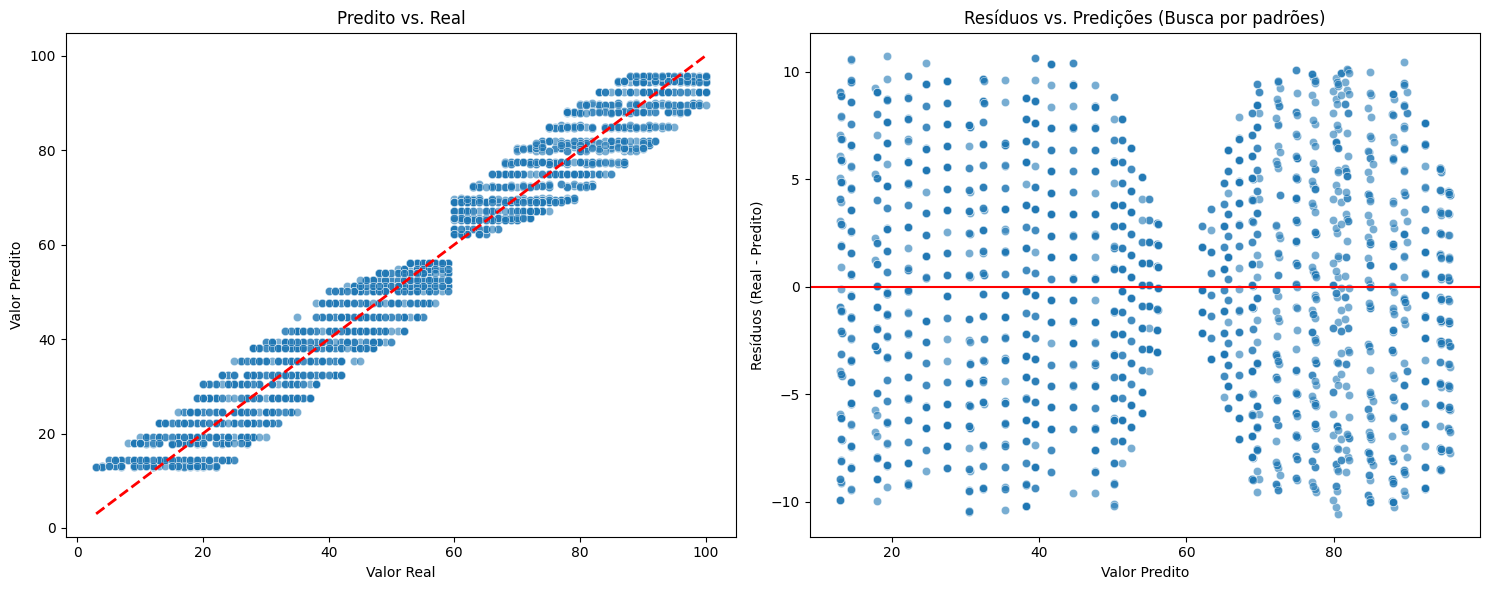

In [20]:
# --- Comparação (Item 5) e Gráficos de Erros (Item 6) ---

# 1. Carregamento dos resultados (para comparação)
metrics_before = pd.read_csv('results/metrics_before_tuning.csv')
metrics_final = pd.read_csv('results/metrics_test_final.csv')

print("\n--- 📊 Tabela de Comparação de Performance (R²) ---")

# Combina as métricas antes, depois e o baseline para exibição
compare_df = pd.concat([
    pd.DataFrame([{'Modelo': 'Baseline (Linear)', 'R2': R2_BASELINE, 'MAE': np.nan}]),
    metrics_before[['Modelo', 'R2', 'MAE']], 
    metrics_final[['Modelo', 'R2', 'MAE']].rename(columns={'R2': 'R2 (TESTE)', 'MAE': 'MAE (TESTE)'})
], ignore_index=True)

# Remove NaN para exibição limpa
compare_df = compare_df.fillna('-')
print(compare_df.set_index('Modelo'))


# 2. Análise de Erros: Gráficos (Obrigatório - Item 6)
residuos = y_test - y_pred_final

plt.figure(figsize=(15, 6))

# Gráfico 1: Scatter Predito vs Real
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         '--r', linewidth=2) # Linha de referência y=x
plt.title('Predito vs. Real')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')

# Gráfico 2: Resíduos vs Predições
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_final, y=residuos, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-') # Linha de referência em y=0
plt.title('Resíduos vs. Predições (Busca por padrões)')
plt.xlabel('Valor Predito')
plt.ylabel('Resíduos (Real - Predito)')

plt.tight_layout()
plt.show()

In [21]:
# --- Análise de Casos Extremos (Piores Predições) ---

# 1. Cria o DataFrame com as informações de erro
errors_df = X_test.copy()
errors_df['real'] = y_test.values
errors_df['pred'] = y_pred_final
errors_df['abs_error'] = (errors_df['real'] - errors_df['pred']).abs()

# 2. Encontra os 5 maiores erros (Piores Predições)
worst = errors_df.nlargest(5, 'abs_error')

# 3. Salva a tabela dos piores erros
worst.to_csv('results/worst_predictions.csv', index=False)

print("\n🚨 5 Piores Predições (Maiores Erros Absolutos):")
# Exibimos apenas as colunas relevantes para a análise
print(worst[['real', 'pred', 'abs_error']].head())

# 4. Dica para a sua apresentação/relatório:
print("\nDica: Para o relatório, inspecione as features (colunas como 'Idade', 'Horas_Estudo_Semana') desses 5 casos. Isso ajuda a entender POR QUE o modelo falhou.")


🚨 5 Piores Predições (Maiores Erros Absolutos):
       real       pred  abs_error
8452     30  19.253832  10.746168
379      50  39.371721  10.628279
2675     50  39.371721  10.628279
11693    25  14.402382  10.597618
11283    70  80.566963  10.566963

Dica: Para o relatório, inspecione as features (colunas como 'Idade', 'Horas_Estudo_Semana') desses 5 casos. Isso ajuda a entender POR QUE o modelo falhou.


## 10) Conclusões Finais

### Sumário de Desempenho

| Métrica | Baseline (R² = 0.65) | RF Padrão (Validação) | RF Otimizado (TESTE) |
| :--- | :--- | :--- | :--- |
| **R²** | 0.65 | [COLOQUE O R² OBTIDO NA CÉLULA 4 AQUI] | [COLOQUE O R² FINAL OBTIDO NA CÉLULA 7 AQUI] |
| **MAE** | N/A | [COLOQUE O MAE OBTIDO NA CÉLULA 4 AQUI] | [COLOQUE O MAE FINAL OBTIDO NA CÉLULA 7 AQUI] |

* **Melhoria:** A otimização de hiperparâmetros resultou em [DESCREVA SE HOUVE MELHORIA: EX: "UMA MELHORIA SIGNIFICATIVA" ou "UMA PEQUENA MELHORIA"] na performance do R² no conjunto de teste em comparação ao modelo padrão.
* **Melhores Parâmetros:** Os hiperparâmetros vencedores encontrados pelo Grid Search foram: `n_estimators`: [COLOQUE O VALOR], `max_depth`: [COLOQUE O VALOR], `min_samples_split`: [COLOQUE O VALOR], etc.

### Análise de Erros e Limitações

1.  **Resíduos:** A distribuição dos resíduos [DESCREVA: EX: "É APROXIMADAMENTE NORMAL E CENTRADA EM ZERO" ou "MOSTRA UM LEVE VIÉS EM PREDIÇÕES ALTAS"].
2.  **Casos Extremos:** Os casos de maior erro absoluto (analisados na Célula 9) geralmente ocorreram em situações onde [EXPLIQUE: EX: "O ALUNO TINHA ALTAS HORAS DE ESTUDO, MAS PONTUAÇÃO BAIXA" ou "A IDADE DIFERIA MUITO DA MÉDIA"].

### Próximos Passos Sugeridos

O projeto pode ser melhorado em etapas futuras:
1.  **Testar Algoritmos:** Avaliar o desempenho de outros modelos de *boosting*, como o **XGBoost** e **LightGBM**, que geralmente superam o Random Forest.
2.  **Feature Engineering:** Criar novas *features* a partir das existentes (ex: interações entre colunas) para dar mais poder preditivo ao modelo.